<a href="https://colab.research.google.com/github/AngKS/practices/blob/master/CIFAR10_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 GAN Model

Article link: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# load dataset
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
# summarize the shape of the dataset
print('Train', train_x.shape, train_y.shape)
print('Test', test_x.shape, test_y.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


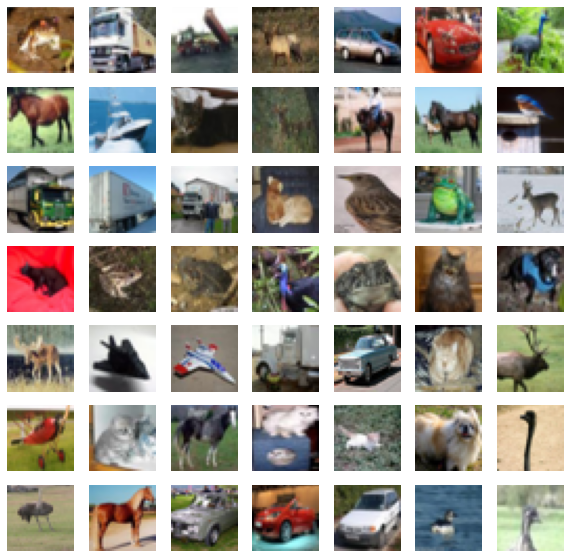

In [3]:
# plot images from the training dataset
plt.figure(figsize=(10,10))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(train_x[i])
plt.show()

In [4]:
# import keras components
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [5]:
# define the standalone descriminator model

def define_desc(in_shape=(32, 32, 3)):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  # Downsampling
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
  

In [6]:
desc_model = define_desc()
desc_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         2

C:\Users\p2004176\.conda\envs\DELE\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
def load_real_samples():
    (train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()

    X = train_x.astype('float32')
    # scale the images from [0,255] to [-1,1]
    
    X = X / 255.0

    return X

In [8]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
  X = dataset[ix]
	# generate 'real' class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [10]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [11]:
# define the generator model

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # upsample to 8X8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # upsample to 16X16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # Upsample to 32X32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model


In [12]:
# define size of latent space
latent_dim = 100
gen_model = define_generator(latent_dim)
gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)      

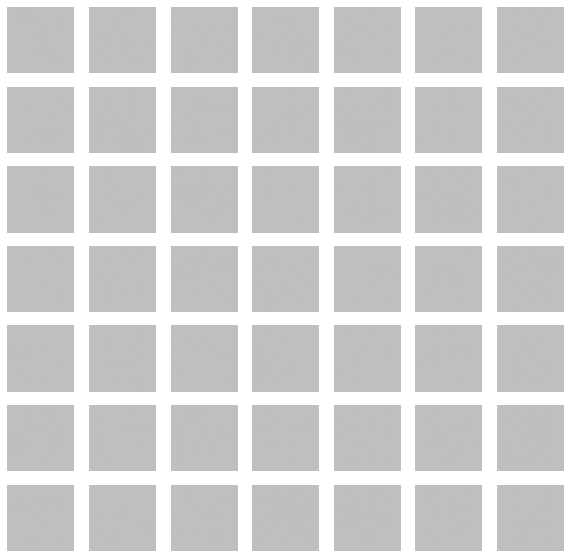

In [13]:
# generate samples
n_samples = 49
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# Scale X from [-1, 1] to [0, 1]
X = (X + 1) / 2.0

plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(7, 7, i+1)
    plt.axis('off')
    plt.imshow(X[i])
plt.show()

In [14]:
def define_GAN(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt)
    return model

In [15]:
latent_dim = 100
d_model = define_desc()
g_model = define_generator(latent_dim)
gan_model = define_GAN(g_model, d_model)
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32, 32, 3)         1467651   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 519425    
Total params: 1,987,076
Trainable params: 1,466,883
Non-trainable params: 520,193
_________________________________________________________________


In [16]:
def train_GAN(gan_model, latent_dim, epochs=200, batch_size=128):
    for i in range(epochs):
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
        gan_model.train_on_batch(x_gan, y_gan)



In [17]:
def create_plots(epoch, examples, n):
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.title(f"Epoch {epoch}")
        plt.imshow((examples[i, :, :]).astype('float32'))

    
    plt.show()


In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, batch_size=128):
    bat_per_epo = int(dataset.shape[0] / batch_size)
    half_batch = batch_size // 2
    for i in range(epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update descriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space for generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size, 1))
            # update generator loss
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print(f"Epoch: {i + 1} / {epochs}   Descriminator Loss[1]: {d_loss1:.3f}    Descriminator Loss[2]: {d_loss2:.3f}    GAN loss: {g_loss:.3f}")
        if (i % 5 == 0):
            create_plots(i, g_model.predict(generate_latent_points(100, 100)), 3)



Epoch: 1 / 100   Descriminator Loss[1]: 0.640    Descriminator Loss[2]: 0.457    GAN loss: 0.342


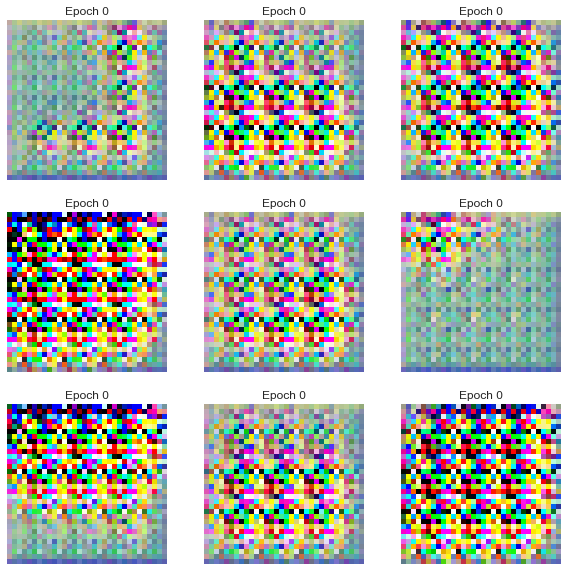

Epoch: 2 / 100   Descriminator Loss[1]: 0.724    Descriminator Loss[2]: 0.673    GAN loss: 0.261
Epoch: 3 / 100   Descriminator Loss[1]: 0.706    Descriminator Loss[2]: 0.673    GAN loss: 0.263
Epoch: 4 / 100   Descriminator Loss[1]: 0.688    Descriminator Loss[2]: 0.703    GAN loss: 0.247
Epoch: 5 / 100   Descriminator Loss[1]: 0.686    Descriminator Loss[2]: 0.700    GAN loss: 0.273
Epoch: 6 / 100   Descriminator Loss[1]: 0.720    Descriminator Loss[2]: 0.614    GAN loss: 0.287


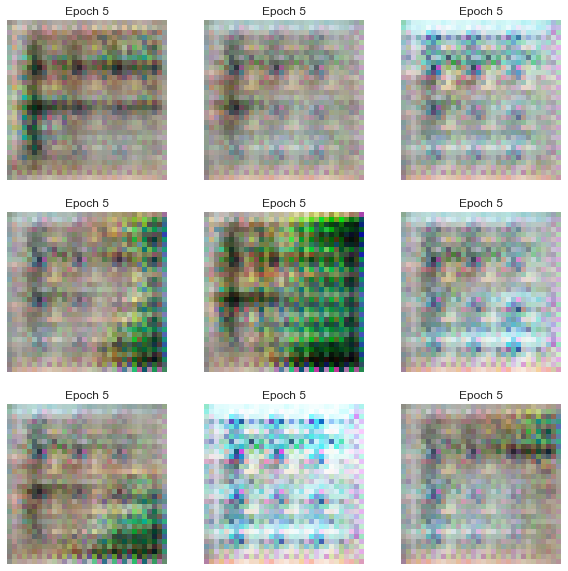

Epoch: 7 / 100   Descriminator Loss[1]: 0.662    Descriminator Loss[2]: 0.769    GAN loss: 0.234
Epoch: 8 / 100   Descriminator Loss[1]: 0.330    Descriminator Loss[2]: 0.443    GAN loss: 0.072
Epoch: 9 / 100   Descriminator Loss[1]: 0.507    Descriminator Loss[2]: 0.431    GAN loss: 0.147
Epoch: 10 / 100   Descriminator Loss[1]: 0.643    Descriminator Loss[2]: 0.697    GAN loss: 0.241
Epoch: 11 / 100   Descriminator Loss[1]: 0.658    Descriminator Loss[2]: 0.674    GAN loss: 0.364


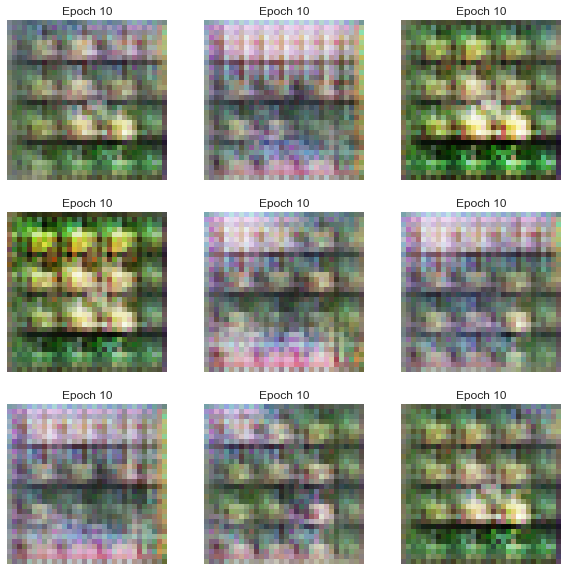

Epoch: 12 / 100   Descriminator Loss[1]: 0.679    Descriminator Loss[2]: 0.739    GAN loss: 0.269
Epoch: 13 / 100   Descriminator Loss[1]: 0.796    Descriminator Loss[2]: 0.559    GAN loss: 0.512
Epoch: 14 / 100   Descriminator Loss[1]: 0.699    Descriminator Loss[2]: 0.626    GAN loss: 0.273
Epoch: 15 / 100   Descriminator Loss[1]: 0.708    Descriminator Loss[2]: 0.647    GAN loss: 0.272
Epoch: 16 / 100   Descriminator Loss[1]: 0.629    Descriminator Loss[2]: 0.687    GAN loss: 0.297


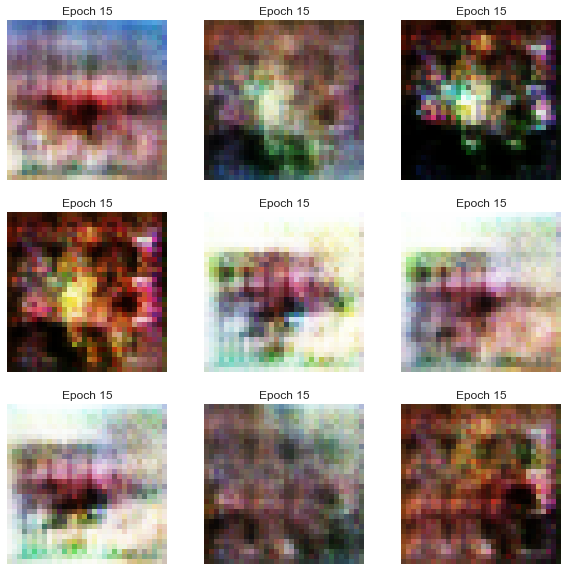

Epoch: 17 / 100   Descriminator Loss[1]: 0.712    Descriminator Loss[2]: 0.677    GAN loss: 0.283
Epoch: 18 / 100   Descriminator Loss[1]: 0.729    Descriminator Loss[2]: 0.707    GAN loss: 0.259
Epoch: 19 / 100   Descriminator Loss[1]: 0.647    Descriminator Loss[2]: 0.679    GAN loss: 0.268
Epoch: 20 / 100   Descriminator Loss[1]: 0.673    Descriminator Loss[2]: 0.696    GAN loss: 0.257
Epoch: 21 / 100   Descriminator Loss[1]: 0.682    Descriminator Loss[2]: 0.660    GAN loss: 0.282


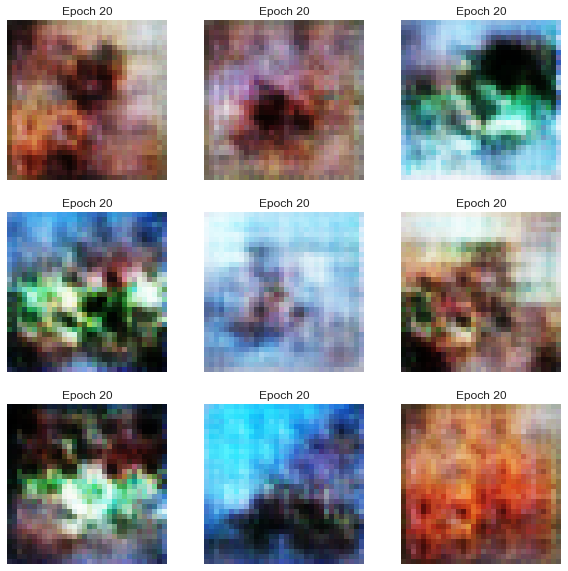

Epoch: 22 / 100   Descriminator Loss[1]: 0.635    Descriminator Loss[2]: 0.729    GAN loss: 0.265
Epoch: 23 / 100   Descriminator Loss[1]: 0.678    Descriminator Loss[2]: 0.663    GAN loss: 0.287
Epoch: 24 / 100   Descriminator Loss[1]: 0.613    Descriminator Loss[2]: 0.757    GAN loss: 0.246
Epoch: 25 / 100   Descriminator Loss[1]: 0.717    Descriminator Loss[2]: 0.658    GAN loss: 0.290
Epoch: 26 / 100   Descriminator Loss[1]: 0.692    Descriminator Loss[2]: 0.657    GAN loss: 0.279


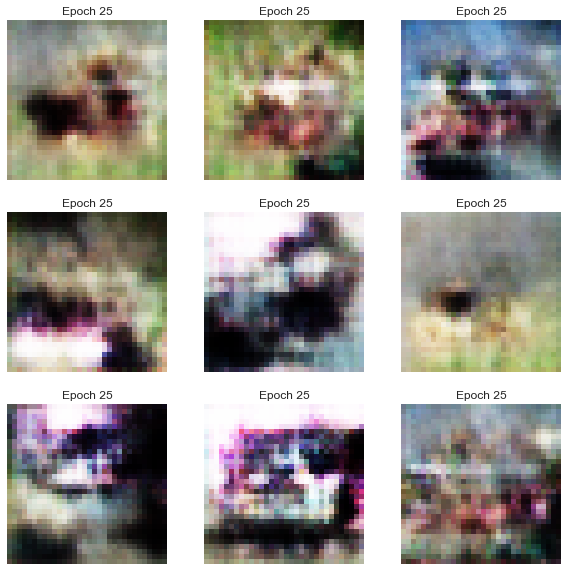

Epoch: 27 / 100   Descriminator Loss[1]: 0.666    Descriminator Loss[2]: 0.700    GAN loss: 0.282
Epoch: 28 / 100   Descriminator Loss[1]: 0.676    Descriminator Loss[2]: 0.701    GAN loss: 0.263
Epoch: 29 / 100   Descriminator Loss[1]: 0.747    Descriminator Loss[2]: 0.646    GAN loss: 0.284
Epoch: 30 / 100   Descriminator Loss[1]: 0.607    Descriminator Loss[2]: 0.734    GAN loss: 0.256
Epoch: 31 / 100   Descriminator Loss[1]: 0.658    Descriminator Loss[2]: 0.652    GAN loss: 0.288


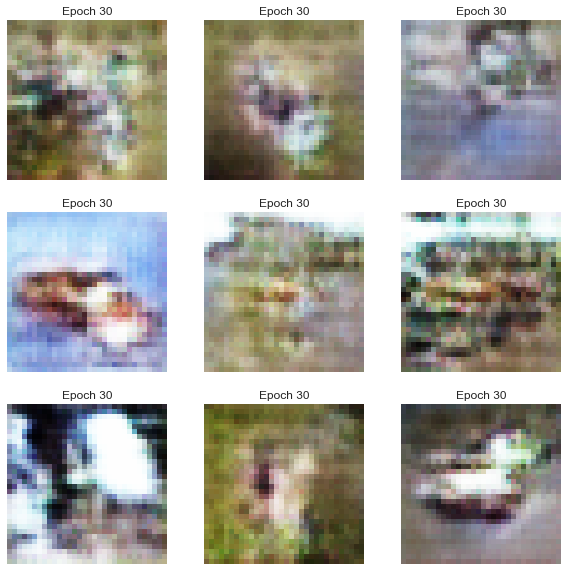

Epoch: 32 / 100   Descriminator Loss[1]: 0.702    Descriminator Loss[2]: 0.668    GAN loss: 0.289
Epoch: 33 / 100   Descriminator Loss[1]: 0.728    Descriminator Loss[2]: 0.646    GAN loss: 0.285
Epoch: 34 / 100   Descriminator Loss[1]: 0.717    Descriminator Loss[2]: 0.690    GAN loss: 0.280
Epoch: 35 / 100   Descriminator Loss[1]: 0.685    Descriminator Loss[2]: 0.660    GAN loss: 0.277
Epoch: 36 / 100   Descriminator Loss[1]: 0.695    Descriminator Loss[2]: 0.667    GAN loss: 0.287


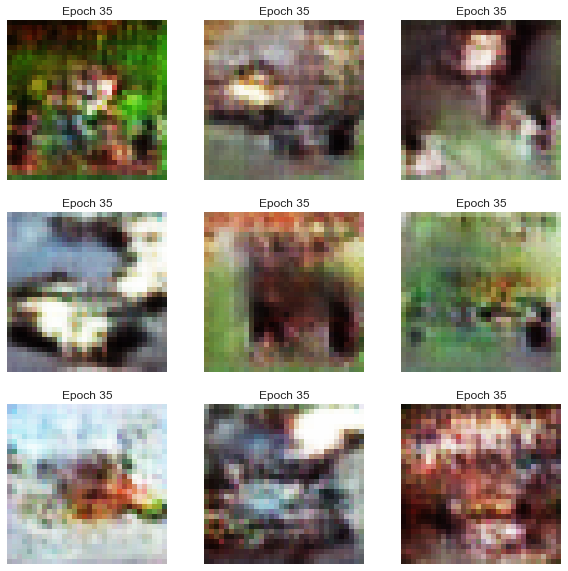

Epoch: 37 / 100   Descriminator Loss[1]: 0.689    Descriminator Loss[2]: 0.662    GAN loss: 0.266
Epoch: 38 / 100   Descriminator Loss[1]: 0.636    Descriminator Loss[2]: 0.660    GAN loss: 0.298
Epoch: 39 / 100   Descriminator Loss[1]: 0.758    Descriminator Loss[2]: 0.636    GAN loss: 0.294
Epoch: 40 / 100   Descriminator Loss[1]: 0.654    Descriminator Loss[2]: 0.667    GAN loss: 0.271
Epoch: 41 / 100   Descriminator Loss[1]: 0.664    Descriminator Loss[2]: 0.694    GAN loss: 0.275


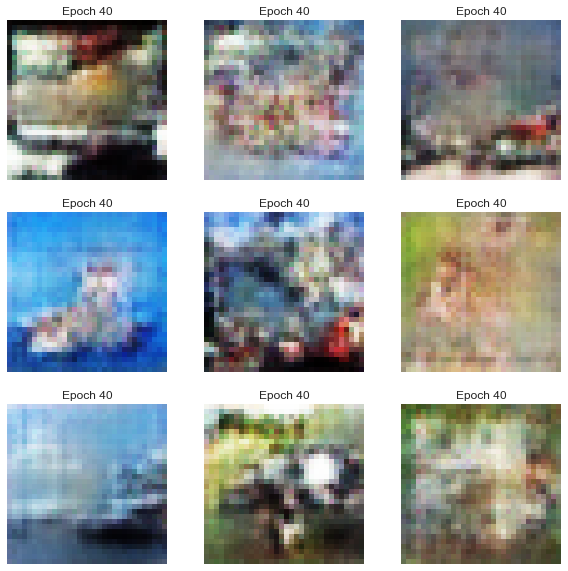

Epoch: 42 / 100   Descriminator Loss[1]: 0.682    Descriminator Loss[2]: 0.695    GAN loss: 0.266
Epoch: 43 / 100   Descriminator Loss[1]: 0.681    Descriminator Loss[2]: 0.688    GAN loss: 0.266
Epoch: 44 / 100   Descriminator Loss[1]: 0.707    Descriminator Loss[2]: 0.654    GAN loss: 0.274
Epoch: 45 / 100   Descriminator Loss[1]: 0.710    Descriminator Loss[2]: 0.682    GAN loss: 0.265
Epoch: 46 / 100   Descriminator Loss[1]: 0.697    Descriminator Loss[2]: 0.677    GAN loss: 0.270


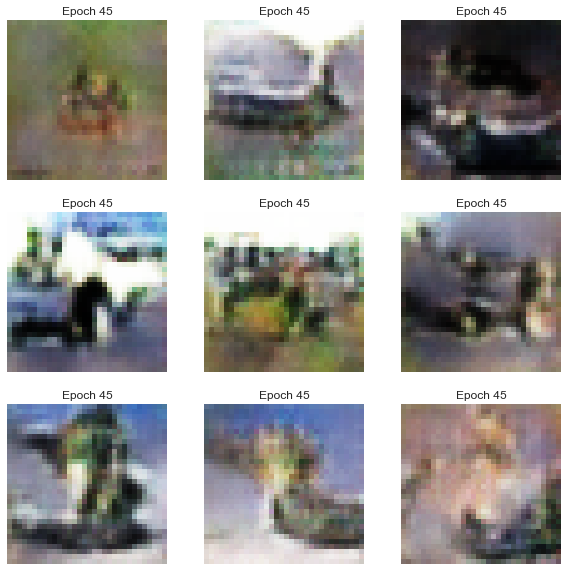

Epoch: 47 / 100   Descriminator Loss[1]: 0.701    Descriminator Loss[2]: 0.672    GAN loss: 0.264
Epoch: 48 / 100   Descriminator Loss[1]: 0.714    Descriminator Loss[2]: 0.703    GAN loss: 0.265
Epoch: 49 / 100   Descriminator Loss[1]: 0.732    Descriminator Loss[2]: 0.671    GAN loss: 0.274
Epoch: 50 / 100   Descriminator Loss[1]: 0.697    Descriminator Loss[2]: 0.671    GAN loss: 0.265
Epoch: 51 / 100   Descriminator Loss[1]: 0.695    Descriminator Loss[2]: 0.689    GAN loss: 0.260


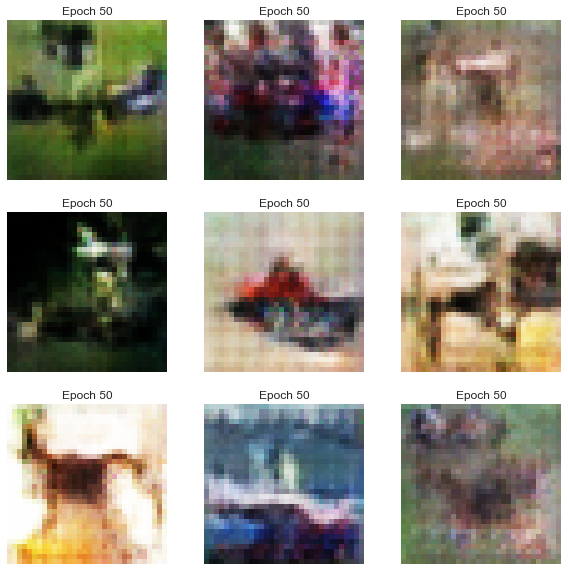

Epoch: 52 / 100   Descriminator Loss[1]: 0.701    Descriminator Loss[2]: 0.679    GAN loss: 0.262
Epoch: 53 / 100   Descriminator Loss[1]: 0.668    Descriminator Loss[2]: 0.679    GAN loss: 0.264
Epoch: 54 / 100   Descriminator Loss[1]: 0.712    Descriminator Loss[2]: 0.673    GAN loss: 0.272
Epoch: 55 / 100   Descriminator Loss[1]: 0.709    Descriminator Loss[2]: 0.673    GAN loss: 0.275
Epoch: 56 / 100   Descriminator Loss[1]: 0.673    Descriminator Loss[2]: 0.690    GAN loss: 0.259


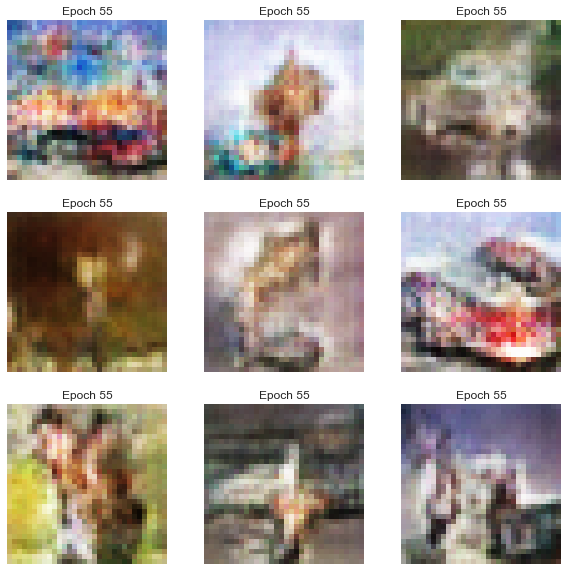

Epoch: 57 / 100   Descriminator Loss[1]: 0.703    Descriminator Loss[2]: 0.687    GAN loss: 0.263
Epoch: 58 / 100   Descriminator Loss[1]: 0.693    Descriminator Loss[2]: 0.685    GAN loss: 0.268
Epoch: 59 / 100   Descriminator Loss[1]: 0.686    Descriminator Loss[2]: 0.689    GAN loss: 0.268
Epoch: 60 / 100   Descriminator Loss[1]: 0.690    Descriminator Loss[2]: 0.685    GAN loss: 0.258
Epoch: 61 / 100   Descriminator Loss[1]: 0.678    Descriminator Loss[2]: 0.710    GAN loss: 0.269


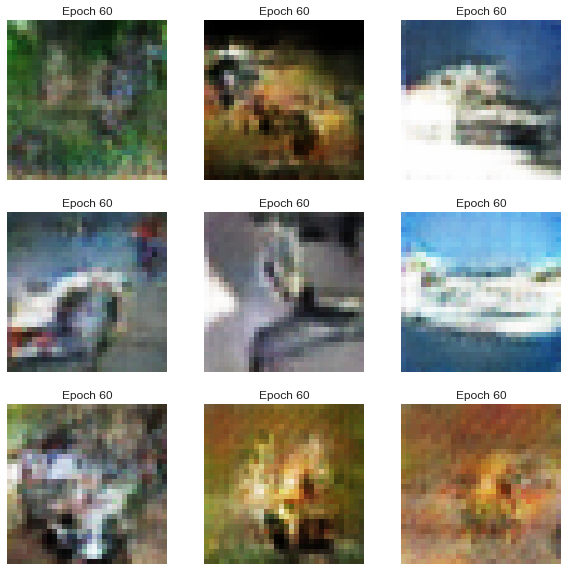

Epoch: 62 / 100   Descriminator Loss[1]: 0.684    Descriminator Loss[2]: 0.691    GAN loss: 0.262
Epoch: 63 / 100   Descriminator Loss[1]: 0.691    Descriminator Loss[2]: 0.685    GAN loss: 0.257
Epoch: 64 / 100   Descriminator Loss[1]: 0.694    Descriminator Loss[2]: 0.678    GAN loss: 0.263
Epoch: 65 / 100   Descriminator Loss[1]: 0.702    Descriminator Loss[2]: 0.701    GAN loss: 0.259
Epoch: 66 / 100   Descriminator Loss[1]: 0.692    Descriminator Loss[2]: 0.684    GAN loss: 0.265


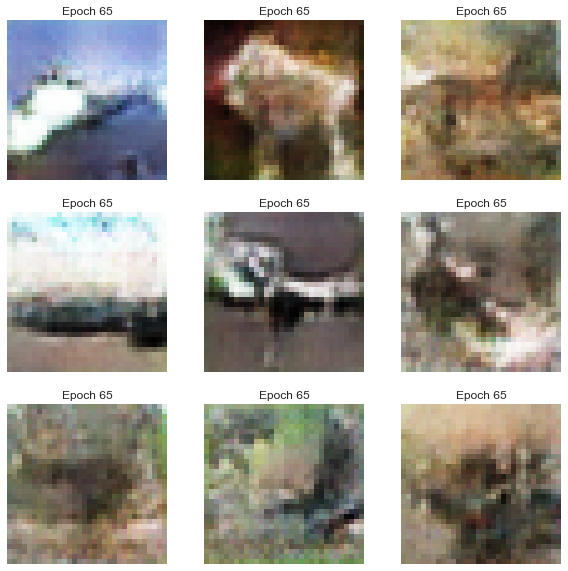

Epoch: 67 / 100   Descriminator Loss[1]: 0.687    Descriminator Loss[2]: 0.686    GAN loss: 0.252
Epoch: 68 / 100   Descriminator Loss[1]: 0.683    Descriminator Loss[2]: 0.681    GAN loss: 0.267
Epoch: 69 / 100   Descriminator Loss[1]: 0.687    Descriminator Loss[2]: 0.683    GAN loss: 0.258
Epoch: 70 / 100   Descriminator Loss[1]: 0.691    Descriminator Loss[2]: 0.685    GAN loss: 0.266
Epoch: 71 / 100   Descriminator Loss[1]: 0.667    Descriminator Loss[2]: 0.709    GAN loss: 0.260


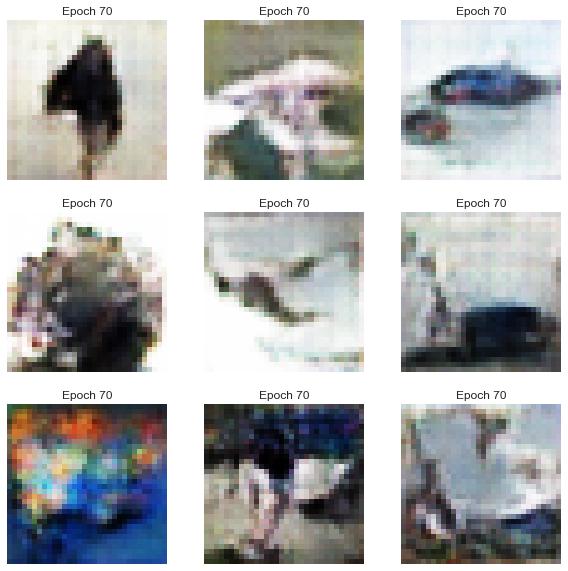

Epoch: 72 / 100   Descriminator Loss[1]: 0.667    Descriminator Loss[2]: 0.676    GAN loss: 0.254
Epoch: 73 / 100   Descriminator Loss[1]: 0.694    Descriminator Loss[2]: 0.667    GAN loss: 0.269
Epoch: 74 / 100   Descriminator Loss[1]: 0.703    Descriminator Loss[2]: 0.686    GAN loss: 0.266
Epoch: 75 / 100   Descriminator Loss[1]: 0.717    Descriminator Loss[2]: 0.684    GAN loss: 0.266
Epoch: 76 / 100   Descriminator Loss[1]: 0.693    Descriminator Loss[2]: 0.695    GAN loss: 0.266


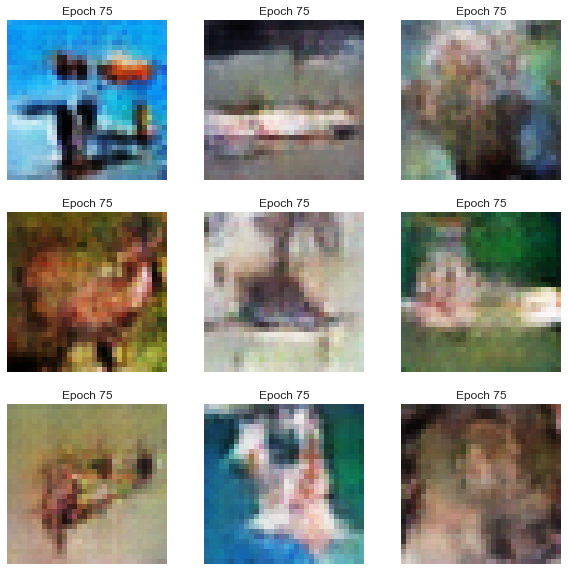

Epoch: 77 / 100   Descriminator Loss[1]: 0.709    Descriminator Loss[2]: 0.698    GAN loss: 0.258
Epoch: 78 / 100   Descriminator Loss[1]: 0.656    Descriminator Loss[2]: 0.687    GAN loss: 0.264
Epoch: 79 / 100   Descriminator Loss[1]: 0.687    Descriminator Loss[2]: 0.668    GAN loss: 0.266
Epoch: 80 / 100   Descriminator Loss[1]: 0.708    Descriminator Loss[2]: 0.677    GAN loss: 0.274
Epoch: 81 / 100   Descriminator Loss[1]: 0.699    Descriminator Loss[2]: 0.681    GAN loss: 0.257


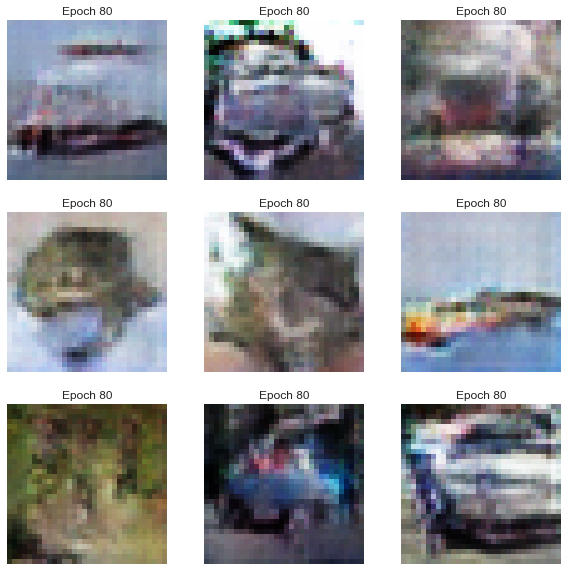

Epoch: 82 / 100   Descriminator Loss[1]: 0.714    Descriminator Loss[2]: 0.680    GAN loss: 0.267
Epoch: 83 / 100   Descriminator Loss[1]: 0.684    Descriminator Loss[2]: 0.666    GAN loss: 0.261
Epoch: 84 / 100   Descriminator Loss[1]: 0.668    Descriminator Loss[2]: 0.680    GAN loss: 0.270
Epoch: 85 / 100   Descriminator Loss[1]: 0.718    Descriminator Loss[2]: 0.662    GAN loss: 0.266
Epoch: 86 / 100   Descriminator Loss[1]: 0.691    Descriminator Loss[2]: 0.697    GAN loss: 0.272


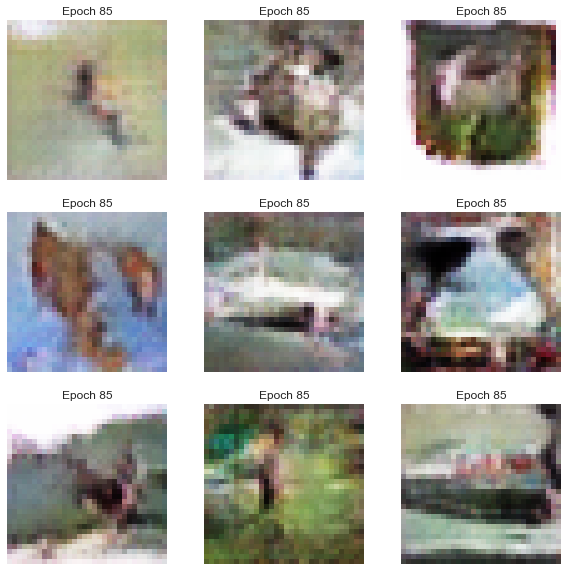

Epoch: 87 / 100   Descriminator Loss[1]: 0.681    Descriminator Loss[2]: 0.684    GAN loss: 0.270
Epoch: 88 / 100   Descriminator Loss[1]: 0.695    Descriminator Loss[2]: 0.655    GAN loss: 0.269
Epoch: 89 / 100   Descriminator Loss[1]: 0.694    Descriminator Loss[2]: 0.675    GAN loss: 0.263
Epoch: 90 / 100   Descriminator Loss[1]: 0.705    Descriminator Loss[2]: 0.675    GAN loss: 0.265
Epoch: 91 / 100   Descriminator Loss[1]: 0.674    Descriminator Loss[2]: 0.690    GAN loss: 0.266


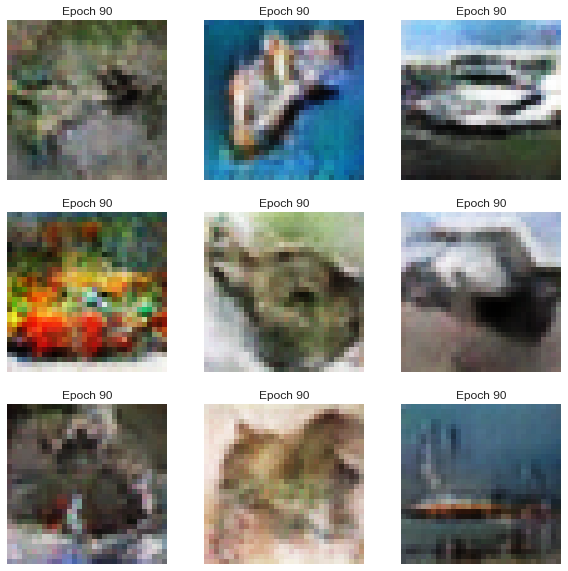

Epoch: 92 / 100   Descriminator Loss[1]: 0.681    Descriminator Loss[2]: 0.657    GAN loss: 0.270
Epoch: 93 / 100   Descriminator Loss[1]: 0.702    Descriminator Loss[2]: 0.696    GAN loss: 0.270
Epoch: 94 / 100   Descriminator Loss[1]: 0.703    Descriminator Loss[2]: 0.680    GAN loss: 0.278
Epoch: 95 / 100   Descriminator Loss[1]: 0.687    Descriminator Loss[2]: 0.780    GAN loss: 0.278
Epoch: 96 / 100   Descriminator Loss[1]: 0.685    Descriminator Loss[2]: 0.662    GAN loss: 0.274


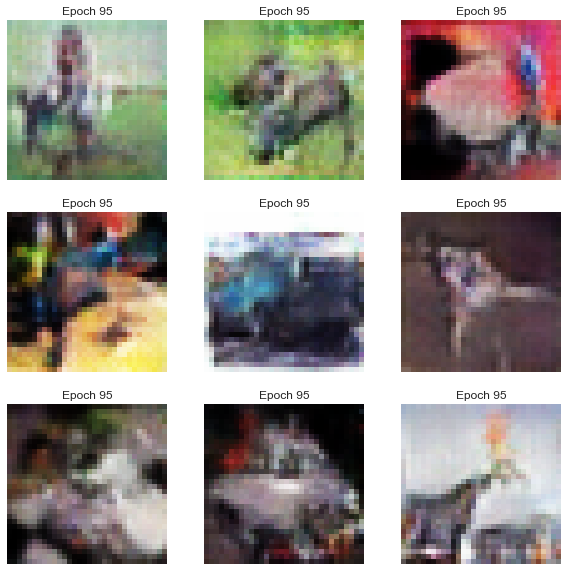

Epoch: 97 / 100   Descriminator Loss[1]: 0.684    Descriminator Loss[2]: 0.674    GAN loss: 0.275
Epoch: 98 / 100   Descriminator Loss[1]: 0.685    Descriminator Loss[2]: 0.662    GAN loss: 0.279
Epoch: 99 / 100   Descriminator Loss[1]: 0.678    Descriminator Loss[2]: 0.710    GAN loss: 0.268
Epoch: 100 / 100   Descriminator Loss[1]: 0.703    Descriminator Loss[2]: 0.703    GAN loss: 0.268


In [19]:
train(g_model, d_model, gan_model, load_real_samples(), latent_dim)